# Does a job training program improve the earnings of disadvantaged workers?

In [1]:
# Silent warnings
import warnings
warnings.filterwarnings("ignore")


# Core
import numpy as np
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab

# Data
import pandas as pd
from sklearn import tree
from sklearn import metrics
from sklearn import neighbors
from sklearn import ensemble


# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('ggplot')
%config InlineBackend.figure_format='retina'

## For this case, you will likely need approximately 4.5 hours to complete mandatory exercises.

## Introduction

**Business Context.** In the 1980s, Robert Lalonde conducted a study to evaluate the effects of training programs on labour workers. He observed the characteristic background data of the individuals involved. Several of them were selected for enrollment in the job training program (the National Supported Work Demonstration). The training program specifically targeted unemployed women, ex-drug addicts, ex-criminal offenders, and high school dropouts.

<img src="data/trainingfailsmain.jpg" width="550" alt="Labour Training">

The Department of Labor is interested in digging deeper into this data and coming up with some actionable insights in order to raise the earnings of disadvantaged workers. They have contracted you as a data science consultant to assist them with this task.

**Business Problem.** Your goal is to evaluate **whether the job training program *causes* the earnings of disadvantaged workers to go up**.

**Analytical Context.** In this case we will continue our discussion of causal inference. We will study the importance of covariate balance and explore how to perform matching to get this balance. We will leverage a lot of the new classification models we have learned for this purpose.

## Examining the data

The Lalonde dataset provides information on annual income for workers who enroll in the training workshop and those who did not enroll in the year subsequent to training. The outcome of interest is `re78` in which we want to know if there was an increase in earnings in 1978:

1. **age**: age in years
2. **educ**: years of schooling
3. **black**: indicator variable for blacks
4. **hisp**: indicator variable for Hispanics
5. **married**: indicator variable for martial status
6. **nodegr**: indicator variable for high school diploma
7. **re74**: real earnings in 1974
8. **re75**: real earnings in 1975
9. **re78**: real earnings in 1978 - this is the outcome of interest
10. **treat**: an indicator variable whether the worker was enrolled in the training workshop

In [2]:
lalonde_df = pd.read_csv('lalonde.csv', index_col=0)
lalonde_df.head()

treat  age  educ  black  hispan  married  nodegree  re74  re75  \
NSW1      1   37    11      1       0        1         1   0.0   0.0   
NSW2      1   22     9      0       1        0         1   0.0   0.0   
NSW3      1   30    12      1       0        0         0   0.0   0.0   
NSW4      1   27    11      1       0        0         1   0.0   0.0   
NSW5      1   33     8      1       0        0         1   0.0   0.0   

            re78  
NSW1   9930.0460  
NSW2   3595.8940  
NSW3  24909.4500  
NSW4   7506.1460  
NSW5    289.7899

treat  age  educ  black  hispan  married  nodegree  re74  re75  \
NSW1      1   37    11      1       0        1         1   0.0   0.0   
NSW2      1   22     9      0       1        0         1   0.0   0.0   
NSW3      1   30    12      1       0        0         0   0.0   0.0   
NSW4      1   27    11      1       0        0         1   0.0   0.0   
NSW5      1   33     8      1       0        0         1   0.0   0.0   

            re78  
NSW1   9930.0460  
NSW2   3595.8940  
NSW3  24909.4500  
NSW4   7506.1460  
NSW5    289.7899

### Exercise 1: (20 min)

#### 1.1

Provide summary statistics for all the variables in the dataset. What can you say about the average income of the population throughout the years? What percentage of the population saw a decrease in income from 1974 to 1975? What do you think happened in 1975?

**Answer.** 

In [3]:
lalonde_df.describe()

treat         age        educ       black      hispan     married  \
count  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000   
mean     0.301303   27.363192   10.268730    0.395765    0.117264    0.415309   
std      0.459198    9.881187    2.628325    0.489413    0.321997    0.493177   
min      0.000000   16.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000   20.000000    9.000000    0.000000    0.000000    0.000000   
50%      0.000000   25.000000   11.000000    0.000000    0.000000    0.000000   
75%      1.000000   32.000000   12.000000    1.000000    0.000000    1.000000   
max      1.000000   55.000000   18.000000    1.000000    1.000000    1.000000   

         nodegree          re74          re75          re78  
count  614.000000    614.000000    614.000000    614.000000  
mean     0.630293   4557.546569   2184.938207   6792.834483  
std      0.483119   6477.964479   3295.679043   7470.730792  
min      0.000000      0.000000      0.000000      0.000000  
25%      0.000000      0.000000      0.000000    238.283425  
50%      1.000000   1042.330000    601.548400   4759.018500  
75%      1.000000   7888.498250   3248.987500  10893.592500  
max      1.000000  35040.070000  25142.240000  60307.930000

treat         age        educ       black      hispan     married  \
count  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000   
mean     0.301303   27.363192   10.268730    0.395765    0.117264    0.415309   
std      0.459198    9.881187    2.628325    0.489413    0.321997    0.493177   
min      0.000000   16.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000   20.000000    9.000000    0.000000    0.000000    0.000000   
50%      0.000000   25.000000   11.000000    0.000000    0.000000    0.000000   
75%      1.000000   32.000000   12.000000    1.000000    0.000000    1.000000   
max      1.000000   55.000000   18.000000    1.000000    1.000000    1.000000   

         nodegree          re74          re75          re78  
count  614.000000    614.000000    614.000000    614.000000  
mean     0.630293   4557.546569   2184.938207   6792.834483  
std      0.483119   6477.964479   3295.679043   7470.730792  
min      0.000000      0.000000      0.000000      0.000000  
25%      0.000000      0.000000      0.000000    238.283425  
50%      1.000000   1042.330000    601.548400   4759.018500  
75%      1.000000   7888.498250   3248.987500  10893.592500  
max      1.000000  35040.070000  25142.240000  60307.930000

_We can see that earnings' mean decreased between 1974 and 1975, making an apparent recovery when measuring in 1978._

_I noticed that earnings are expressed in real amounts, and 1975 saw a reduction in **real** wages (after adjusting by price index) in the USA, according to [this source](https://www.census.gov/library/publications/1977/demo/p60-105.html)._ 

In [4]:
lalonde_df['decrease7475']=lalonde_df['re75']-lalonde_df['re74']
lalonde_df['decrease7475']=lalonde_df['decrease7475'].apply(lambda x:1 if x < 0 else 0)

In [5]:
lalonde_df.sample(5)

treat  age  educ  black  hispan  married  nodegree       re74  \
NSW15        1   17     7      1       0        0         1      0.000   
PSID380      0   34    12      1       0        1         0      0.000   
PSID38       0   25    12      0       0        1         0  11381.380   
NSW10        1   33    12      0       0        1         0      0.000   
PSID326      0   45     8      1       0        0         1   3299.405   

             re75         re78  decrease7475  
NSW15       0.000   3023.87900             0  
PSID380     0.000  18716.88000             0  
PSID38   7467.435   4162.75600             1  
NSW10       0.000  12418.07000             0  
PSID326     0.000     31.03226             1

treat  age  educ  black  hispan  married  nodegree       re74  \
NSW15        1   17     7      1       0        0         1      0.000   
PSID380      0   34    12      1       0        1         0      0.000   
PSID38       0   25    12      0       0        1         0  11381.380   
NSW10        1   33    12      0       0        1         0      0.000   
PSID326      0   45     8      1       0        0         1   3299.405   

             re75         re78  decrease7475  
NSW15       0.000   3023.87900             0  
PSID380     0.000  18716.88000             0  
PSID38   7467.435   4162.75600             1  
NSW10       0.000  12418.07000             0  
PSID326     0.000     31.03226             1

In [6]:
var7475=lalonde_df['decrease7475'].sum()/lalonde_df['decrease7475'].count()
print("The porcentage of people whose income was reduced between 1974 and 1975 is {:.1%}".format(var7475))

The porcentage of people whose income was reduced between 1974 and 1975 is 46.4%
The porcentage of people whose income was reduced between 1974 and 1975 is 46.4%


In [7]:
lalonde_df.drop(columns=['decrease7475'],inplace=True)

#### 1.2 
    
What percentage of the workers in our dataset are in the treatment group? Find the difference in means and medians of earnings between the control group and the treatment group. Is the difference of means statistically significant?

**Note:** Remember that the *treatment and control groups* correspond to the sets of workers that were enrolled and not enrolled in the job training program, respectively. We can check if a worker is part of the treatment group by simply checking the value of the  `treat` column.

**Answer.**

In [8]:
p_treat=lalonde_df.treat.mean()
print("The porcentage of people in the treatment group is {:.1%}".format(p_treat))

The porcentage of people in the treatment group is 30.1%
The porcentage of people in the treatment group is 30.1%


In [9]:
lalonde_df.groupby(['treat'])['re74','re75','re78'].agg(['mean','median','count'])

re74                         re75                         re78  \
              mean    median count         mean    median count         mean   
treat                                                                          
0      5619.236506  2547.047   429  2466.484443  1086.726   429  6984.169742   
1      2095.573689     0.000   185  1532.055314     0.000   185  6349.143530   

                       
         median count  
treat                  
0      4975.505   429  
1      4232.309   185

re74                         re75                         re78  \
              mean    median count         mean    median count         mean   
treat                                                                          
0      5619.236506  2547.047   429  2466.484443  1086.726   429  6984.169742   
1      2095.573689     0.000   185  1532.055314     0.000   185  6349.143530   

                       
         median count  
treat                  
0      4975.505   429  
1      4232.309   185

In [10]:
lalonde_df.loc[lalonde_df.treat==1,'re74'].mean()

2095.573688648649

2095.573688648649

_From now on, I'll use ```re78```to compare earnings._

In [11]:
results=pd.DataFrame(lalonde_df.groupby(['treat'])['re78'].agg(['mean','median']))
results=results.reset_index()
results

treat         mean    median
0      0  6984.169742  4975.505
1      1  6349.143530  4232.309

treat         mean    median
0      0  6984.169742  4975.505
1      1  6349.143530  4232.309

_The mean and median differences are:_

In [12]:
print(results.diff().iloc[1,:])

treat       1.000000
mean     -635.026212
median   -743.196000
Name: 1, dtype: float64
treat       1.000000
mean     -635.026212
median   -743.196000
Name: 1, dtype: float64


_And we can see differences in mean and median when grouping by ```treat```._

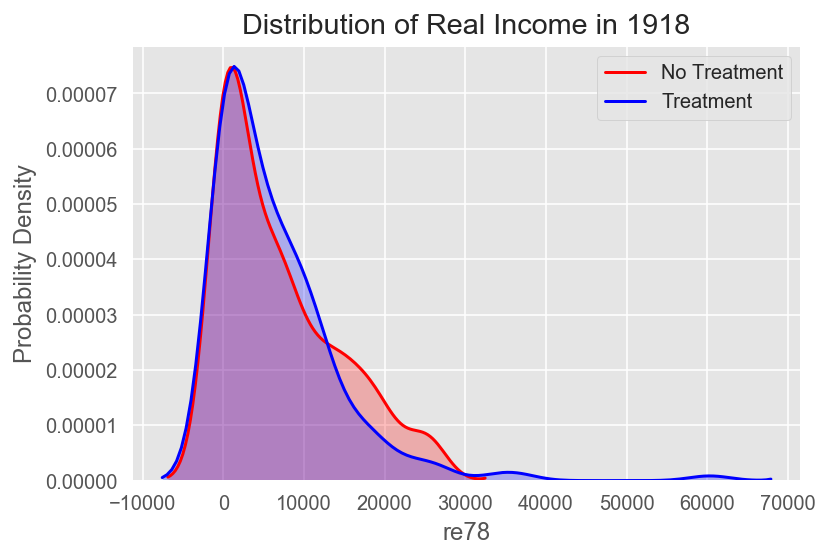

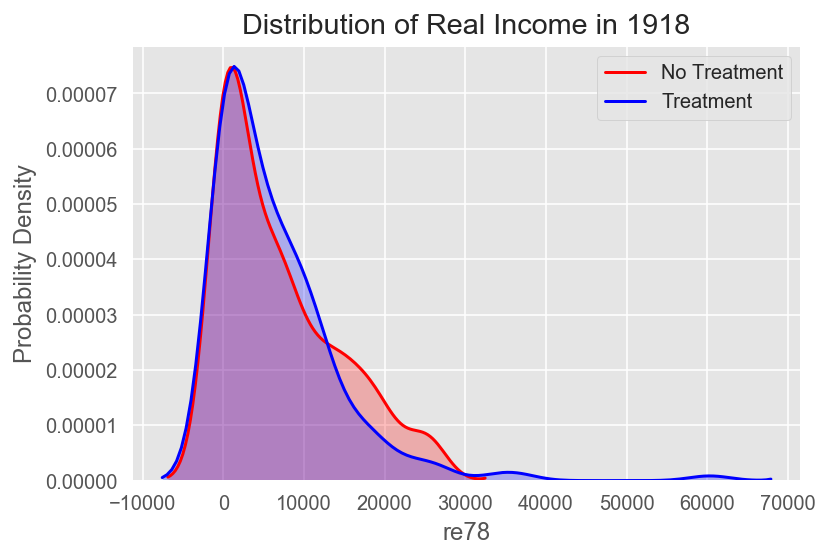

In [13]:
sns.kdeplot(data=lalonde_df.loc[lalonde_df.treat==0,'re78'],color='r',shade='True',Label='No Treatment')
sns.kdeplot(data=lalonde_df.loc[lalonde_df.treat==1,'re78'],color='b',shade='True',Label='Treatment')
 
plt.title('Distribution of Real Income in 1918')    
plt.xlabel('re78') 
plt.ylabel('Probability Density');

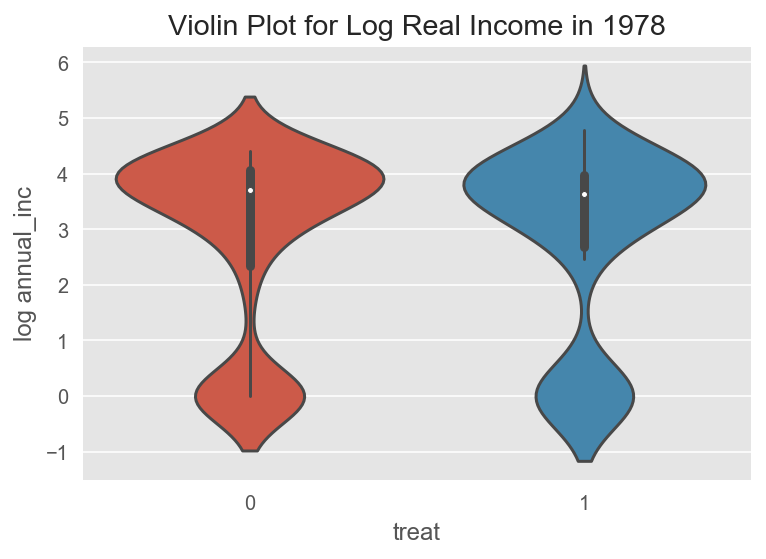

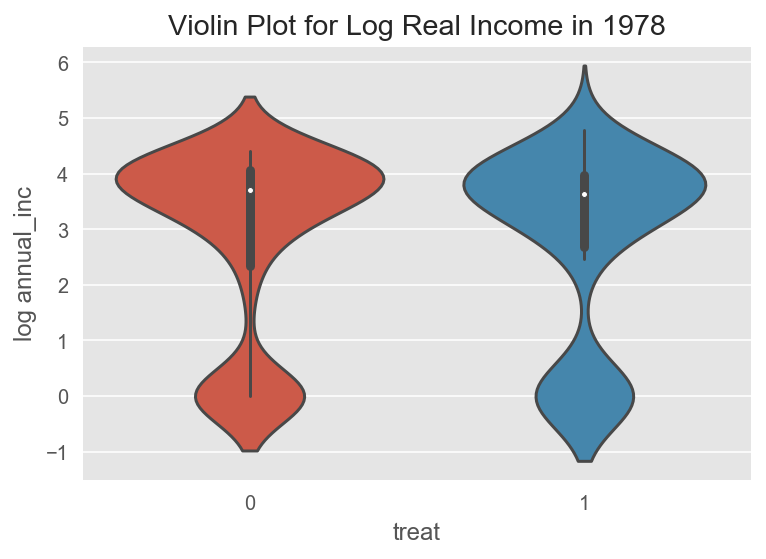

In [14]:
ax = sns.violinplot(x=lalonde_df['treat'], y=np.log10(1+lalonde_df['re78']));
ax.set(ylabel='log annual_inc')
ax.set_title(label='Violin Plot for Log Real Income in 1978');

_When using a log scale, its seems that there is a bimodality, but other than that eyeballing is not very conclusive. We'll use the t-test to check wether there is a difference between treatment and control groups._

In [15]:
from scipy import stats


t, p = stats.ttest_ind(lalonde_df.loc[lalonde_df['treat'] == 1, 're78'],
                         lalonde_df.loc[lalonde_df['treat'] == 0, 're78'])
print("t = " + str(t))
print("p = " + str(p))

t = -0.9663522254463778
p = 0.3342496685909654
t = -0.9663522254463778
p = 0.3342496685909654


_The p-value is greater than the alpha level: p <.05. We cannot reject the null hypothesis that there is no difference between means. I don't have strong evidence to consider the null hypothesis false._

#### 1.3

Does your previous result mean that the treatment had a negative impact? Why or why not?

**Answer.**

_The only conclusion we can safely get to at this point is that the treatment not necessarily have an impact on the mean value for ```re78```. In spite of the mean value giving me that impression, we can't assert that the treatment had a negative impact._

_____

Before we start our exploration on causality, let's perform some simple setup:

1. We separate the `treat` (treatment) indicator from our dataset. We will want to use this as our objective variable to fit models to later
2. We are interested in knowing the treatment effect on `re78` (revenue/earnings in 1978)

In [16]:
#First, let's reset the indexes
cleaned_df=lalonde_df.reset_index().drop(['index'],axis=1)

#Create seperate structure for data and target 
treatment = cleaned_df['treat']
rev78 = cleaned_df['re78']
cleaned_df = cleaned_df.drop(['treat', 're78'], axis=1)

## Assessing balance between the control group and the treatment group

Suppose we want to assess whether balance has been achieved for a particular feature $x = age$. That is, we would like to check whether the treatment and control groups have similar distributions of ages. We can look at **Standardized Mean Differences (SMD)**, which is calculated as follows: let $(\bar{x}_t,s_t^2)$ and $(\bar{x}_c, s_c^2)$ denote the mean and variance corresponding to the treatment and control groups of the particular feature of interest. Then, the SMD is defined as the value:

$$\mathrm{SMD}(x)=\frac{\bar{x}_{t}-{\bar{x}_{c}}}{\sqrt{\frac{s^{2}_{t} + s^{2}_{c}}{2}}}.$$

We can calculate the SMD for every feature. If our calculated SMD is 1, then that means there is a 1 standard deviation difference in means. The benefit of having standard deviation in the denominator is that this number becomes insensitive to the scale of the feature. 

After computing this measurement for all of our features, there is a rule of thumb that is commonly used to determine whether that feature is balanced or not (similar to the idea of using 0.05 as a threshold for $p$ - values):

1. **SMD < 0.1**: We say that the feature is balanced. In general, for a **randomized trial**, the SMD for all of the covariates should typically fall into this bucket.
2. **SMD is between 0.1 and 0.2**:  Not necessarily balanced, but small enough that people are usually not too worried about them. Sometimes, even after performing matching, there might still be a few covariates whose SMD falls in this range.
3. **SMD > 0.2**: Values that are greater than this threshold are considered seriously imbalanced.

In [17]:
lalonde_df.columns

Index(['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree',
       're74', 're75', 're78'],
      dtype='object')

Index(['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree',
       're74', 're75', 're78'],
      dtype='object')

### Exercise 2: (30 min)

#### 2.1

Assess covariate balance between the treatment and control groups. What features (covariates) are imbalanced between the control group and the treatment group in this dataset?

**Answer.**

In [18]:
def SMD(df, var_treatment):
    
    
    
    
    def legend(smd_value):
        if smd_value<=0.1:
            text='OK'
            
        elif smd_value>0.1 and smd_value<0.2:
            text='Not balanced, but acceptable'
        
        else:
            text='Serioulsy Imbalanced'

        return text

    
    list_var=[]
    list_val=[]
    
    my_vars=[var for var in df.columns if var!=var_treatment]
    for _,var in enumerate(my_vars):
    
   
        # group1: Series or NumPy array
        # group2: Series or NumPy array
        # returns a floating point number
    
        group1=df.loc[df[var_treatment]==0,var]
        group2=df.loc[df[var_treatment]==1,var]
    
        diff = group1.mean() - group2.mean()
    
        #Using a general length
        #Should size matter?
        #n1, n2 = len(group1), len(group2)
        var1 = group1.var()
        var2 = group2.var()
    
        # Calculate the pooled threshold 
    
        #pooled_var = (n1*var1 + n2*var2) / (n1+n2)
        pooled_var=(var1+var2)/2
    
    # Calculate value
        d1 = abs(diff / np.sqrt(pooled_var))
        list_var.append(var)
        list_val.append(d1)
    
    
    
    result=pd.DataFrame(zip(list_var,list_val),columns=['Variable Name','SMD value'])
    result.sort_values(by='Variable Name',inplace=True)
    
    result['text']=result['SMD value'].apply(legend)
    
    return result
                 

In [19]:
SMD(lalonde_df,'treat')

Variable Name  SMD value                  text
0           age   0.241904  Serioulsy Imbalanced
2         black   1.667719  Serioulsy Imbalanced
1          educ   0.044755                    OK
3        hispan   0.276940  Serioulsy Imbalanced
4       married   0.719492  Serioulsy Imbalanced
5      nodegree   0.235048  Serioulsy Imbalanced
6          re74   0.595752  Serioulsy Imbalanced
7          re75   0.287002  Serioulsy Imbalanced
8          re78   0.083708                    OK

Variable Name  SMD value                  text
0           age   0.241904  Serioulsy Imbalanced
2         black   1.667719  Serioulsy Imbalanced
1          educ   0.044755                    OK
3        hispan   0.276940  Serioulsy Imbalanced
4       married   0.719492  Serioulsy Imbalanced
5      nodegree   0.235048  Serioulsy Imbalanced
6          re74   0.595752  Serioulsy Imbalanced
7          re75   0.287002  Serioulsy Imbalanced
8          re78   0.083708                    OK

_Using SMD as an criterium, only ```educ``` and ```re78``` are balanced. All other features are over 0.2  after using ```treat```as a grouper._

#### 2.2
Make plots which show the histograms for both the treatment and control groups of the imbalanced covariates.

**Answer.**

In [20]:
checked_vars=lalonde_df.columns

In [21]:
checked_vars

Index(['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree',
       're74', 're75', 're78'],
      dtype='object')

Index(['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree',
       're74', 're75', 're78'],
      dtype='object')

In [22]:
imbalanced_vars=[var for var in checked_vars if var not in ['educ','re78']]

In [23]:
imbalanced_vars

['treat', 'age', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']

['treat', 'age', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']

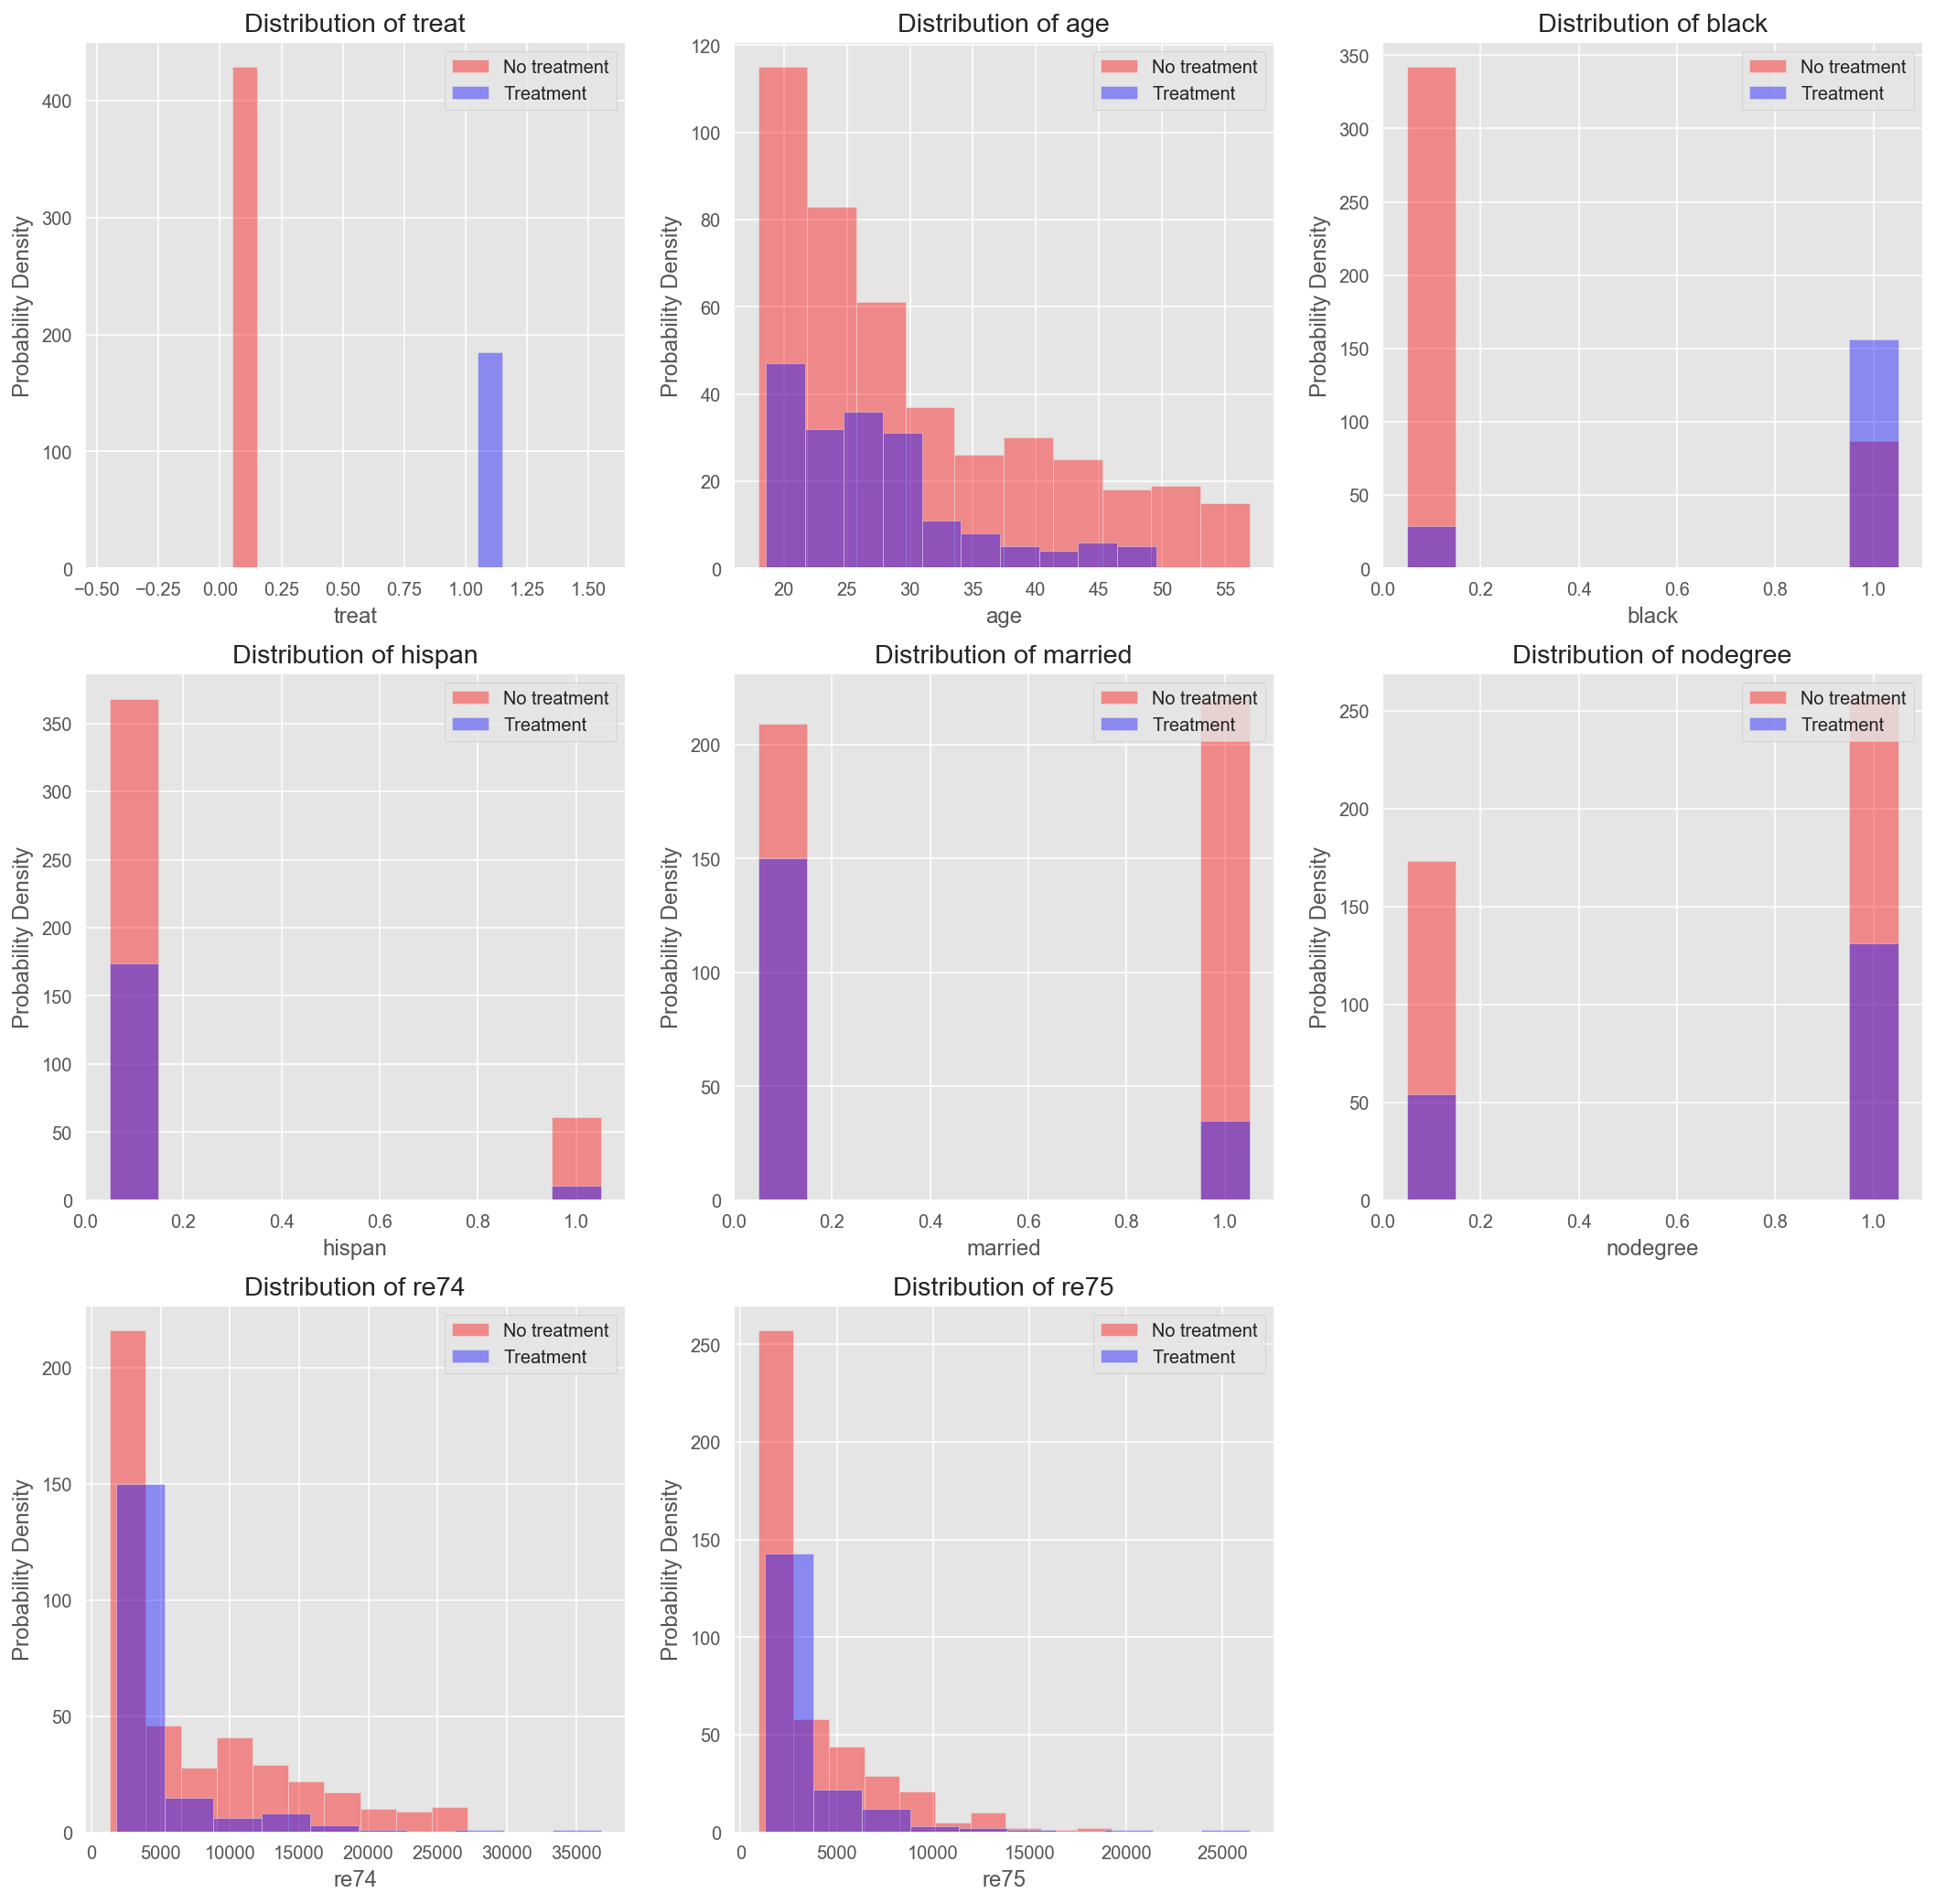

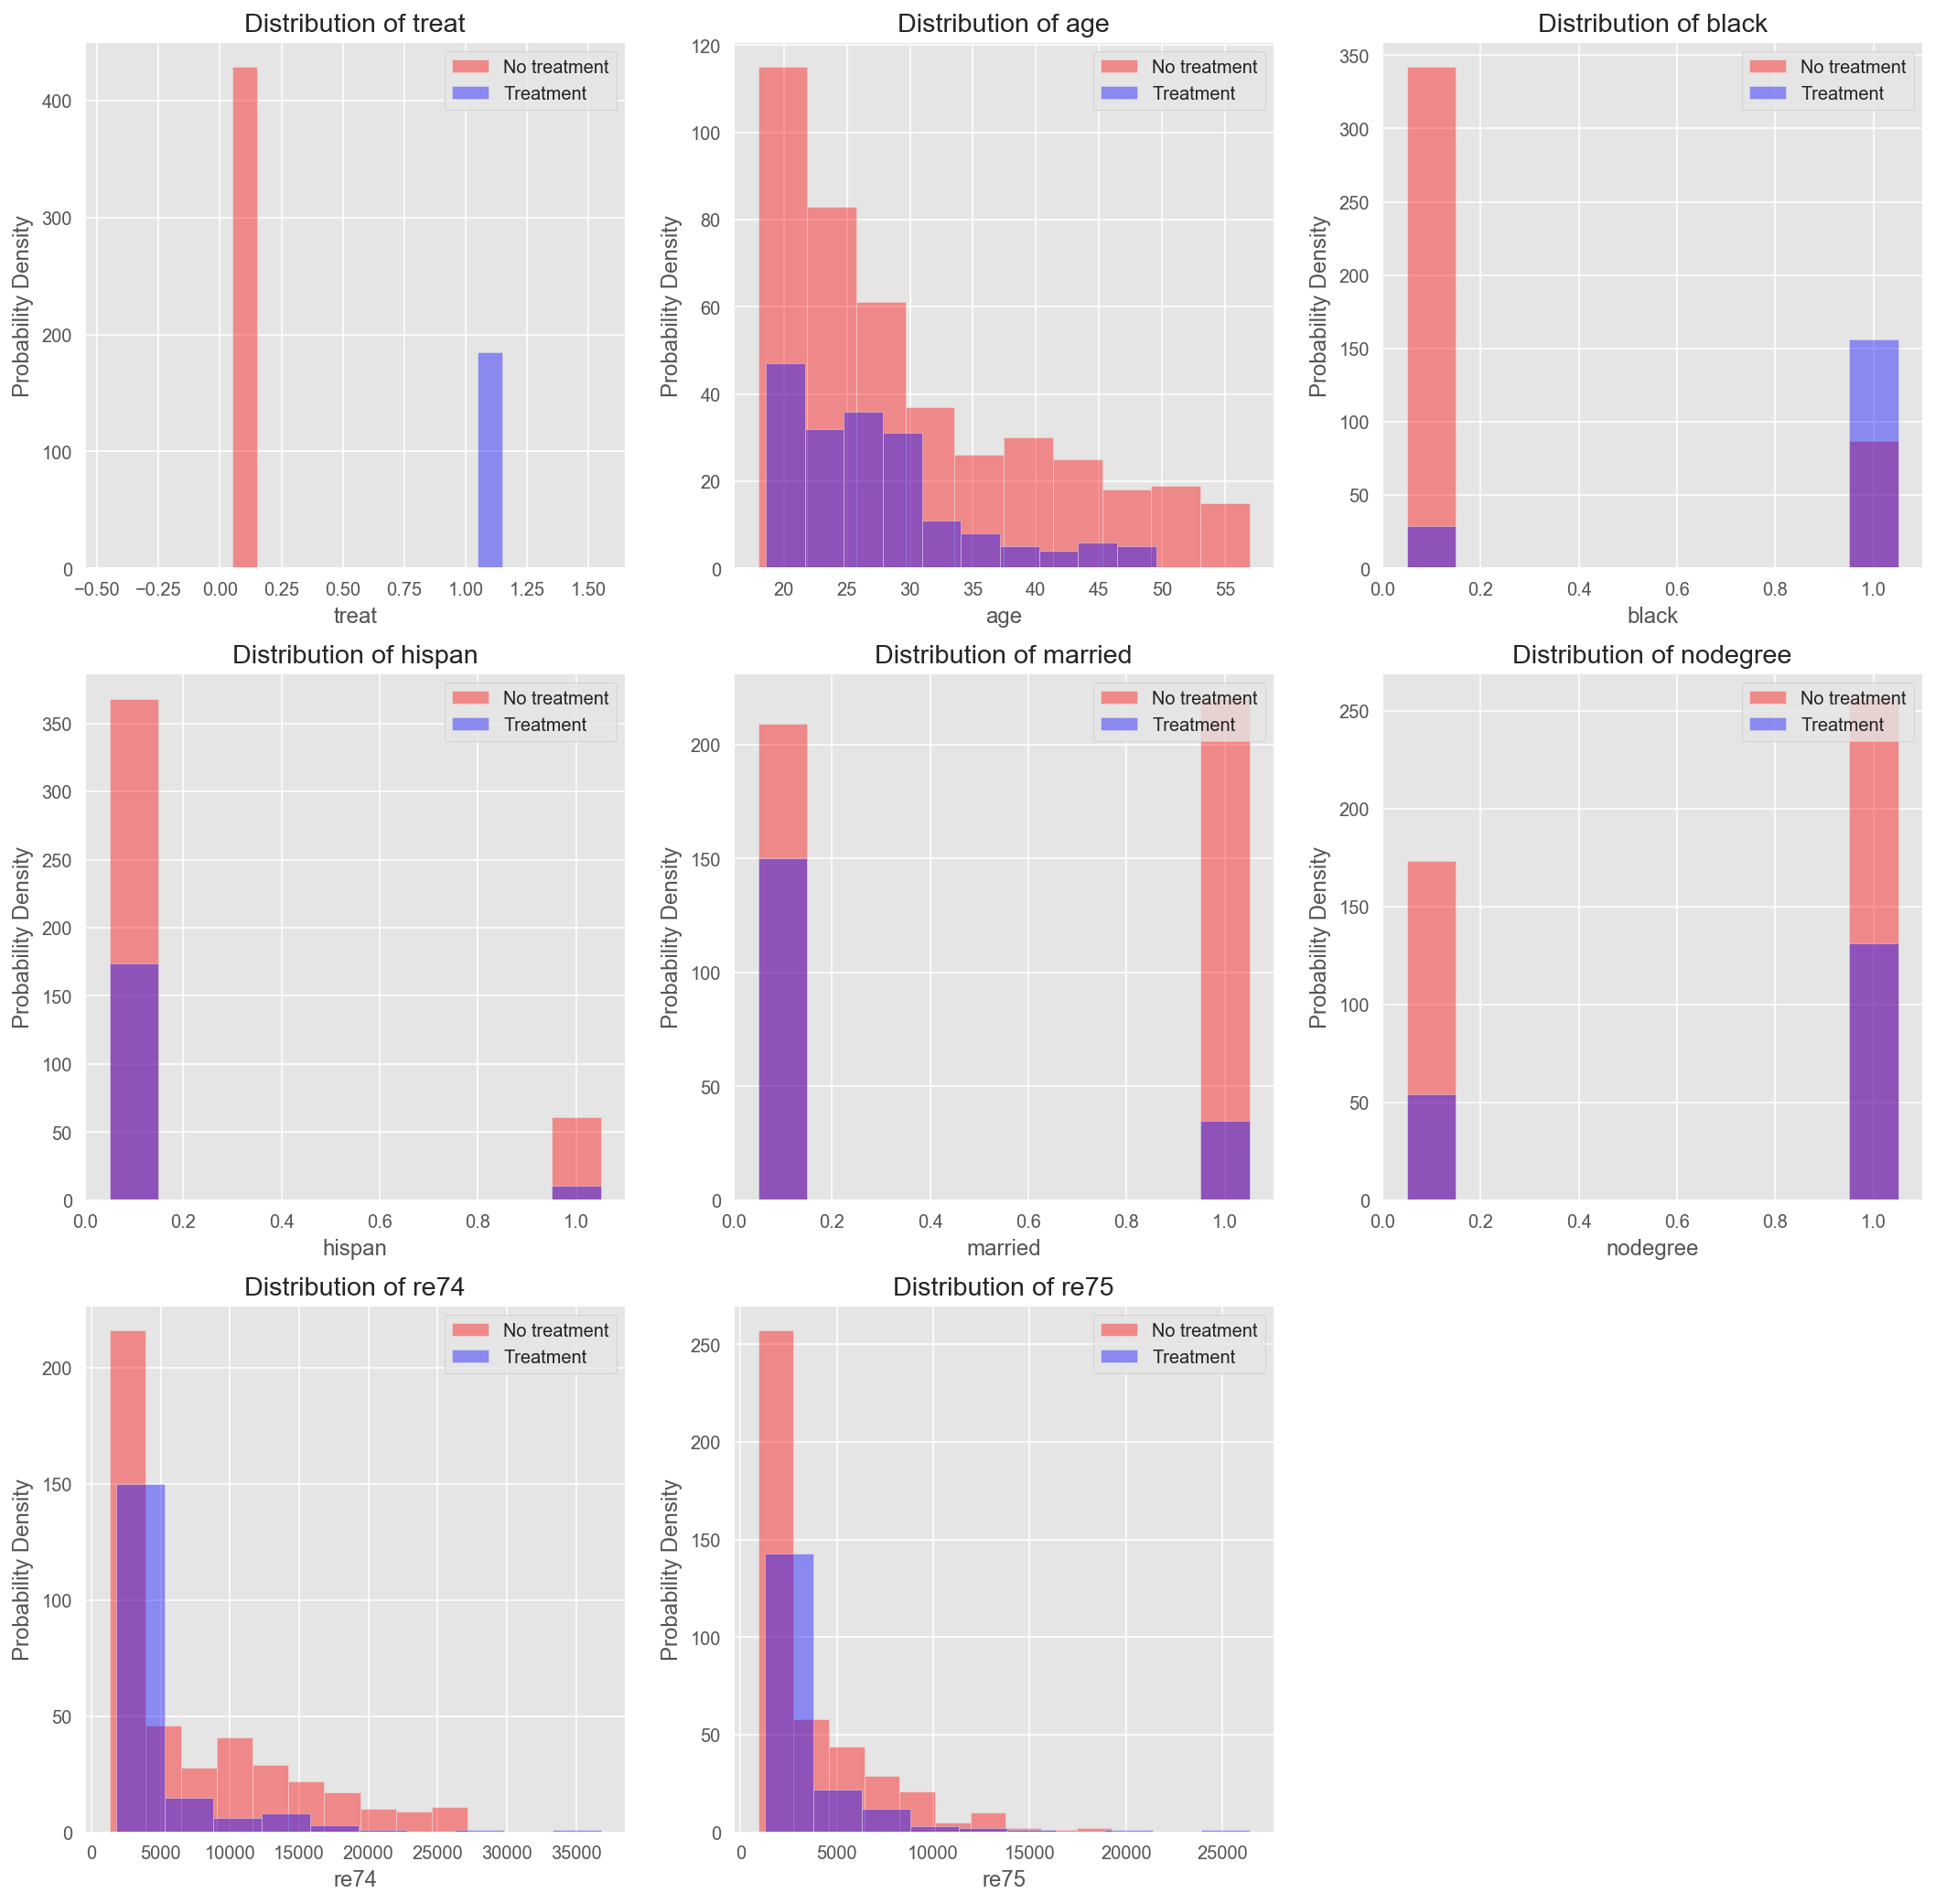

In [24]:
plt.figure(figsize=(18,18))
for i,imb_var in enumerate(imbalanced_vars):
    
    plt.subplot(3,3,i+1)

    
    plt.hist(x=lalonde_df.loc[lalonde_df.treat==0,imb_var],color='r',
             alpha=0.4,label='No treatment',align='right')

    plt.hist(x=lalonde_df.loc[lalonde_df.treat==1,imb_var],color='b',
             alpha=0.4,label='Treatment',align='right')

    plt.legend(loc='upper right')
 
    plt.title('Distribution of '+str(imb_var))    
    plt.xlabel(str(imb_var)) 
    plt.ylabel('Probability Density')
    

## Propensity score matching using logistic regression 

In order to balance the covariates of the control and treatment groups, we will use **matching**. Remember that we used matching in Case 7.5 to balance a population of prisoners to evaluate the effectiveness of a program aiming to reduce recidivism. Thus, the situation here is quite similar.
    
In Case 7.5 we used the *Euclidean distance* on the sample data to create the matching: for each individual of the treatment group, we would find the closest (in Euclidean distance) individual in the control group to match on. Although this method is attractive in general, we may have instances in which the balancing of some particular feature is more important than others. Say the employment program was aiming to create a positive impact within the Hispanic community and a higher proportion of individuals in the treatment group were Hispanic. The Euclidean distance would not take this into account, and we may end up comparing the effect of the treatment between Hispanics and other ethnicities.

We can alleviate this issue by using a metric that takes into account the characteristics of the treatment group. In this context, a metric called the **propensity score** helps us do the matching on select features in an efficient way. The key idea is that *the features that are correlated with the probability of a worker being selected into the treatment group affect our causal results*. A propensity score is this probability. The propensity score for subject $i$, denoted as $\pi_i$ is defined as:

$\pi_i$ = P(Subject $i$ is given training given their features $X_i$)
 
As an example, if a person had a propensity score of 0.3, that would mean that given their particular covariates, there was a 30% chance that they were placed in the treatment group. We can calculate this score by fitting a classification model to our data, where the input features are our covariates, and the output is whether that person was part of the treatment group or not.

### Exercise 3: (35 min)

#### 3.1 

Estimate the propensity scores using a logistic regression. Build a logistic regression model where the outcome variable is whether a subject was in the treatment group or not, and the covariates are all the other variables except `re78`. How would you interpret the predicted values output by the model? 

**Answer.**

In [25]:
lalonde_df.columns

Index(['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree',
       're74', 're75', 're78'],
      dtype='object')

Index(['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree',
       're74', 're75', 're78'],
      dtype='object')

In [26]:
lalonde_df.sample(4)

treat  age  educ  black  hispan  married  nodegree       re74  \
PSID33       0   27    12      0       0        1         0  12270.890   
PSID242      0   45    12      0       0        0         0   4473.006   
NSW132       1   28    11      1       0        0         1      0.000   
PSID202      0   20     9      0       1        1         1      0.000   

              re75       re78  
PSID33   7709.1290   7806.829  
PSID242   608.7097      0.000  
NSW132   1284.0790  60307.930  
PSID202  1283.6610      0.000

treat  age  educ  black  hispan  married  nodegree       re74  \
PSID33       0   27    12      0       0        1         0  12270.890   
PSID242      0   45    12      0       0        0         0   4473.006   
NSW132       1   28    11      1       0        0         1      0.000   
PSID202      0   20     9      0       1        1         1      0.000   

              re75       re78  
PSID33   7709.1290   7806.829  
PSID242   608.7097      0.000  
NSW132   1284.0790  60307.930  
PSID202  1283.6610      0.000

In [27]:
# code the discrete variable by the specification above
data=lalonde_df.iloc[:,:-1]
data.columns

Index(['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree',
       're74', 're75'],
      dtype='object')

Index(['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree',
       're74', 're75'],
      dtype='object')

In [28]:
vars_to_cat=['treat','black','hispan','married','nodegree']
vars_not_cat=['age','educ','re74','re75']

In [29]:
for var in vars_to_cat:
    data[var]=pd.Categorical(data[var])
    data[var]= data[var].cat.codes

_I'll use scaling:_

In [30]:
from sklearn.preprocessing import MinMaxScaler
mms=MinMaxScaler()

In [31]:
data[vars_not_cat] = mms.fit_transform(data[vars_not_cat])

In [32]:
X, y = data.iloc[:,1:],data.iloc[:,0]

In [33]:
X.sample(5)

age      educ  black  hispan  married  nodegree      re74  \
PSID223  0.871795  0.388889      0       0        1         1  0.327439   
NSW37    0.230769  0.277778      1       0        0         1  0.000000   
NSW126   0.282051  0.500000      1       0        1         1  0.000000   
PSID208  0.000000  0.500000      0       0        0         1  0.000000   
PSID198  0.128205  0.777778      0       0        0         0  0.241329   

             re75  
PSID223  0.038025  
NSW37    0.000000  
NSW126   0.037166  
PSID208  0.047282  
PSID198  0.052907

age      educ  black  hispan  married  nodegree      re74  \
PSID223  0.871795  0.388889      0       0        1         1  0.327439   
NSW37    0.230769  0.277778      1       0        0         1  0.000000   
NSW126   0.282051  0.500000      1       0        1         1  0.000000   
PSID208  0.000000  0.500000      0       0        0         1  0.000000   
PSID198  0.128205  0.777778      0       0        0         0  0.241329   

             re75  
PSID223  0.038025  
NSW37    0.000000  
NSW126   0.037166  
PSID208  0.047282  
PSID198  0.052907

In [34]:
y.sample(5)

PSID13     0
PSID266    0
PSID222    0
PSID27     0
PSID126    0
Name: treat, dtype: int8

PSID13     0
PSID266    0
PSID222    0
PSID27     0
PSID126    0
Name: treat, dtype: int8

In [35]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs', tol=10**-4,  
                             fit_intercept=True, 
                             multi_class='multinomial')

_**Assumption**:Since I'm using this model to fit a propensity score on known data, I'll use the entire X as the train set, assuming that there will be no more data to predict._

In [36]:
clf.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
lalonde_df.treat.value_counts()

0    429
1    185
Name: treat, dtype: int64

0    429
1    185
Name: treat, dtype: int64

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.874
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.874


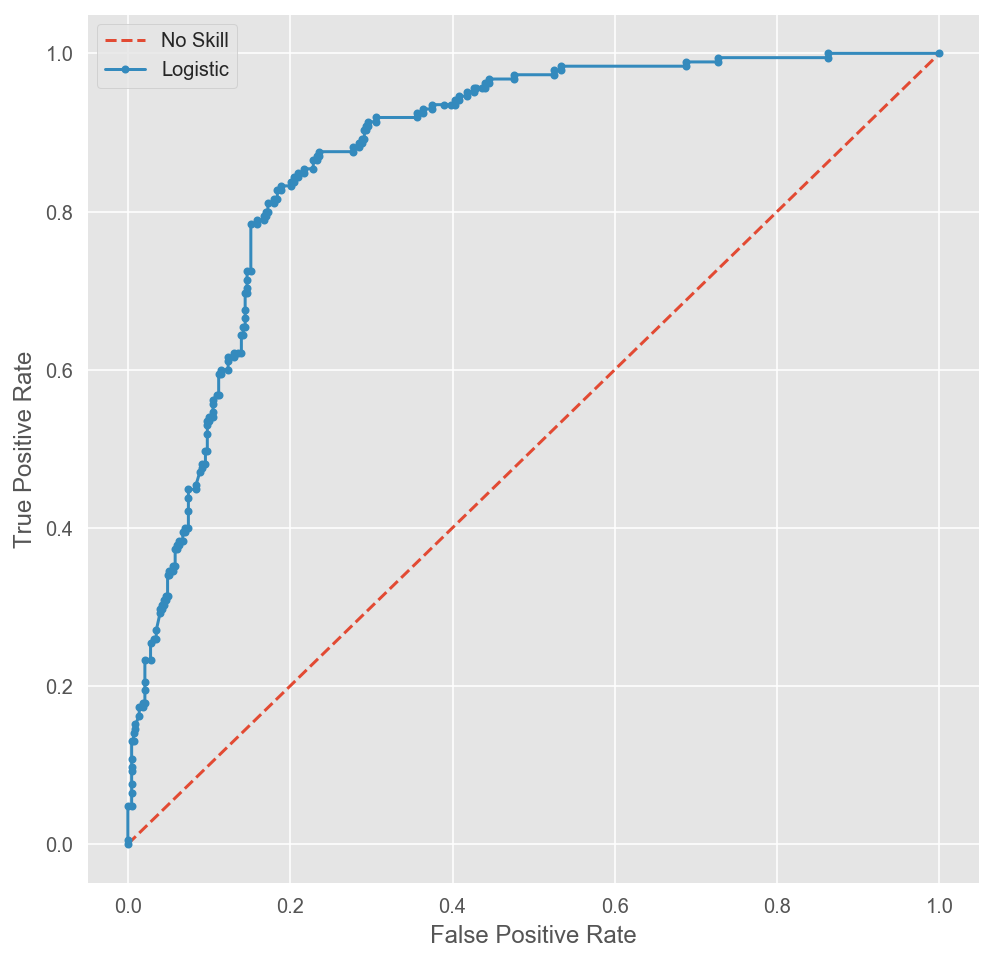

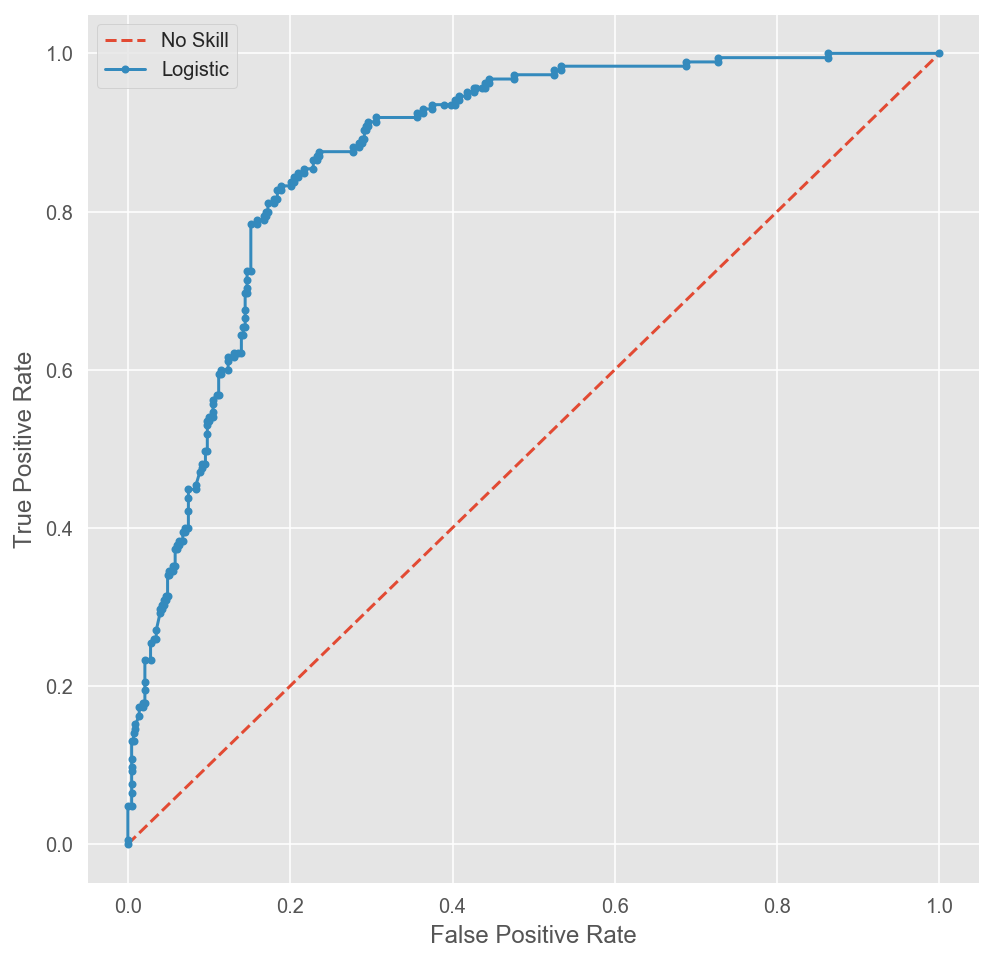

In [38]:
plt.figure(figsize=(8,8))
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix,f1_score
from sklearn.metrics import roc_auc_score

# predict probabilities
ns_probs = [0 for _ in range(len(y))]

lr_probs = clf.predict_proba(X)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y, ns_probs)
lr_auc = roc_auc_score(y, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

_The model fits the data reasonably well, when comparing to guessing with no model._

In [39]:
y_pred_lr=clf.predict(X)
confusion_matrix(y,y_pred_lr)

array([[363,  66],
       [ 40, 145]])

array([[363,  66],
       [ 40, 145]])

In [40]:
f1_score(y,y_pred_lr)

0.7323232323232323

0.7323232323232323

In [41]:
print('intercept:', clf.intercept_)
print('coefficient:', clf.coef_)

intercept: [-1.72467138]
coefficient: [[ 0.1820739   0.815354    1.46078932  0.39717124 -0.40282943  0.24526425
  -0.78587545  0.26165461]]
intercept: [-1.72467138]
coefficient: [[ 0.1820739   0.815354    1.46078932  0.39717124 -0.40282943  0.24526425
  -0.78587545  0.26165461]]


In [42]:
numpy_data = clf.coef_
df_coef = pd.DataFrame(data=numpy_data.T,columns=['coefs'])
df_coef['var_name']=X.columns

In [43]:
pd.DataFrame(zip(clf.intercept_,['Intercept']))

0          1
0 -1.724671  Intercept

0          1
0 -1.724671  Intercept

In [44]:
df_intercept=pd.DataFrame(zip(clf.intercept_,['Intercept']),columns=['coefs','var_name'])

In [45]:
df_coef=pd.concat([df_intercept,df_coef])

In [46]:
df_coef

coefs   var_name
0 -1.724671  Intercept
0  0.182074        age
1  0.815354       educ
2  1.460789      black
3  0.397171     hispan
4 -0.402829    married
5  0.245264   nodegree
6 -0.785875       re74
7  0.261655       re75

coefs   var_name
0 -1.724671  Intercept
0  0.182074        age
1  0.815354       educ
2  1.460789      black
3  0.397171     hispan
4 -0.402829    married
5  0.245264   nodegree
6 -0.785875       re74
7  0.261655       re75


#### 3.2

Use `.predict()`  to obtain the propensity scores of individuals in our dataset. Save the the results with the name `pscore_logit` (these will be used later). In addition, make plots which show the distribution for both the treatment and control groups of propensity scores.

**Answer.**

In [47]:
pscore_logit=clf.predict_proba(X)[:,1]

In [48]:
mask=y==1

In [49]:
pos_pscores=pscore_logit[mask]
neg_pscores=pscore_logit[~mask]

In [50]:
pos_pscores.shape

(185,)

(185,)

In [51]:
neg_pscores.shape

(429,)

(429,)

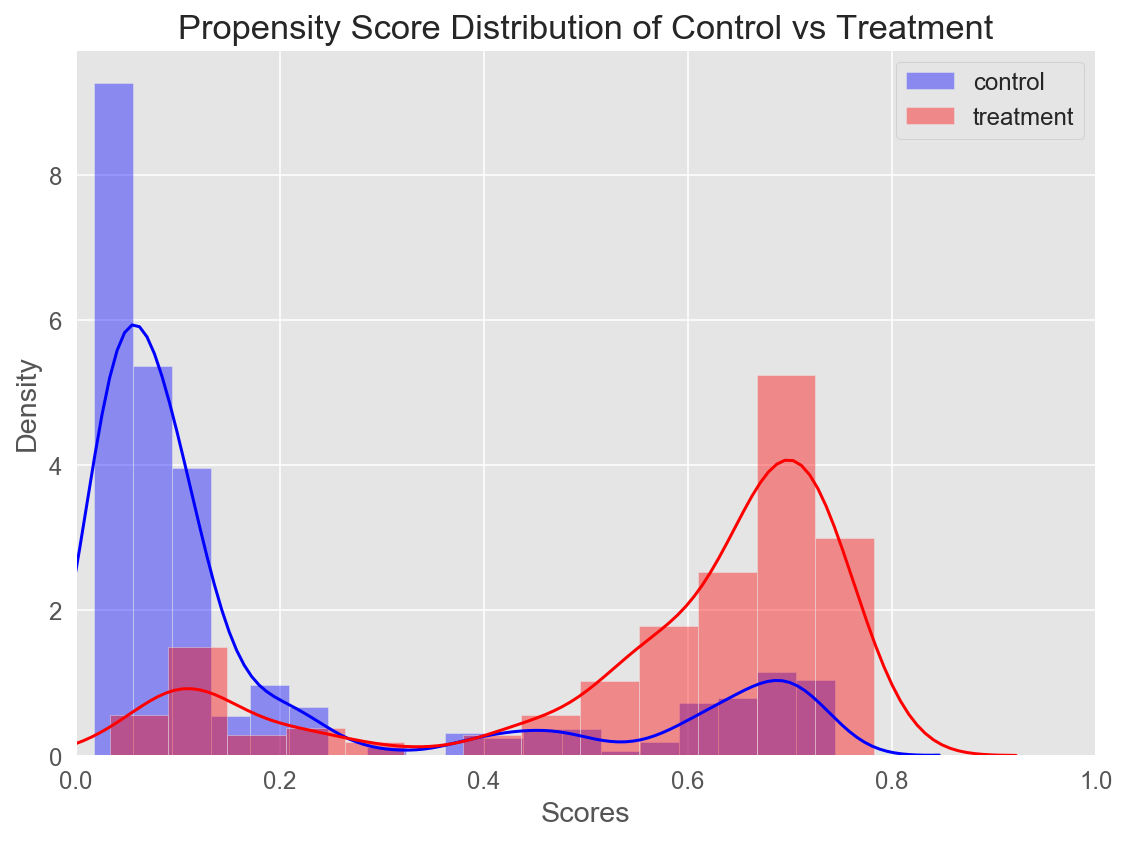

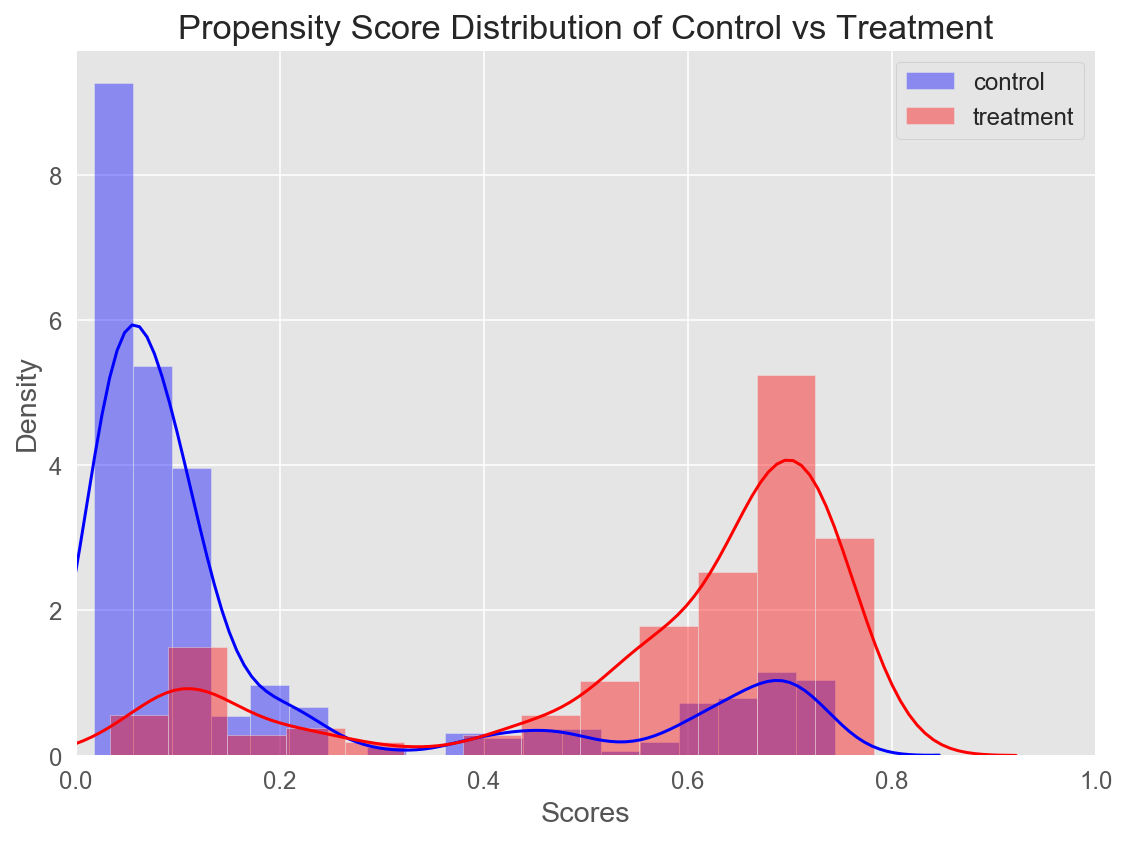

In [52]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

sns.distplot(neg_pscores, label='control',color='blue')
sns.distplot(pos_pscores, label='treatment',color='red')
plt.xlim(0, 1)
plt.title('Propensity Score Distribution of Control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()


### Matching using $k$-nearest neighbors

We are going to match each treated subject with a control subject using nearest neighbors matching on the estimated propensity score. Here, we use another popular clustering algorithm: the **$k$-nearest neighbors ($k$-NN) algorithm**. This algorithm is quite similar to the one we used in Case 7.5. However, instead of finding the single control individual with the closest propensity score, it finds the $k$ control individuals with the closest propensity scores. The use of $k>1$ is handy for classification purposes: if each individual lies in a category, we can classify a new individual by finding its $k$ nearest neighbors and use the most common category of its neighbors as the selected category for the new individual. 

### Exercise 4 (50 min):

In this exercise, we will use the `sklearn.neighbors` function [`NearestNeighbors`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors.kneighbors) to find, for each subject in the treatment group, the $k=5$ subjects in the control group with the closest propensity scores.

#### 4.1

Separate the propensity scores `pscore_logit` found in Exercise 3 for treatment and control groups. Call these `treat_pscores` and `control_pscores` respectively. Use the `control_pscores` to train a $k$-NN algorithm with $k=5$.

**Hint:** Load the model using `knn = neighbors.NearestNeighbors(n_neighbors=5,metric='euclidean')`. You may want to reshape the control scores using `control_pscores.reshape(-1,1)`.

**Answer.**

In [53]:
from sklearn.neighbors import NearestNeighbors

In [54]:
treat_pscores=pos_pscores
control_pscores=neg_pscores

In [55]:
treat_pscores.shape, control_pscores.shape

((185,), (429,))

((185,), (429,))

_I will use a function to get a better control of the process._

In [56]:
def get_similar(pos_pscore_vec, neg_pscore_vec,nn=5):
    
    #Fitting on control scores
    knn = NearestNeighbors(n_neighbors=nn, metric='euclidean')
    
    #reshaping
    
    knn.fit(neg_pscore_vec.reshape(-1, 1))
    
    
    #"Predictinig" on treatment scores
    distances, indices = knn.kneighbors(pos_pscore_vec.reshape(-1, 1))
    
    #Return distances and indices separately
    sim_distances = distances
    sim_indices = indices
    return sim_distances, sim_indices

#### 4.2

Find the indices of the five nearest neighbors using the method `.kneighbors()` applied to `treat_pscores`. 

**Answer.**

_Using the previous function, I get the indices._

In [57]:
sim_distances, sim_indices = get_similar(treat_pscores,control_pscores,)

In [58]:
sim_distances.shape

(185, 5)

(185, 5)

In [59]:
sim_indices.shape

(185, 5)

(185, 5)

#### 4.3

Match the treatment and control groups using the closest of the five neighbors found above. Your output should be a pair of `DataFrames`, each with $185$ rows from the `lalonde_df`. The first should correspond to the treatment group and the second should correspond to the matched control group.

**Answer.**

_Using just the **closest** neighbor:_

In [60]:
indices=sim_indices[:,0]

In [61]:
df_pos=lalonde_df[mask]
df_neg=lalonde_df[~mask].iloc[indices]
df_matched=pd.concat([df_pos, df_neg], axis=0)

In [62]:
df_matched.shape

(370, 10)

(370, 10)

In [63]:
df_matched.sample(5)

treat  age  educ  black  hispan  married  nodegree       re74  \
PSID227      0   17    11      0       1        0         1      0.000   
PSID291      0   16     6      1       0        0         1      0.000   
NSW182       1   25    14      1       0        1         0  35040.070   
NSW45        1   20    11      1       0        0         1      0.000   
NSW171       1   17    10      1       0        0         1   1291.468   

                re75       re78  
PSID227    873.67740   7759.542  
PSID291     44.75806      0.000  
NSW182   11536.57000  36646.950  
NSW45        0.00000   3972.540  
NSW171    5793.85200   5522.788

treat  age  educ  black  hispan  married  nodegree       re74  \
PSID227      0   17    11      0       1        0         1      0.000   
PSID291      0   16     6      1       0        0         1      0.000   
NSW182       1   25    14      1       0        1         0  35040.070   
NSW45        1   20    11      1       0        0         1      0.000   
NSW171       1   17    10      1       0        0         1   1291.468   

                re75       re78  
PSID227    873.67740   7759.542  
PSID291     44.75806      0.000  
NSW182   11536.57000  36646.950  
NSW45        0.00000   3972.540  
NSW171    5793.85200   5522.788

_Checking treat and experimental # of cases in the new matched dataframe._

In [64]:
df_matched.treat.value_counts()

1    185
0    185
Name: treat, dtype: int64

1    185
0    185
Name: treat, dtype: int64



### Propensity score distribution plot after matching

Let's take a glance at the distribution of propensity score after matching. Both groups have similar distributions on the propensity score. This means we have reach a balance in both groups. This enables us to further analyze the causality effect of the treatment.

### Exercise 5 (20 min):

Make a plot which shows the histograms of propensity scores for the control and treatment groups after matching. Compare your results with the plot in Exercise 3.2.

**Answer.**

In [65]:
df_matched_scaled=df_matched.copy()

In [66]:
df_matched_scaled[vars_not_cat] = mms.transform(df_matched[vars_not_cat])

In [67]:
df_matched_scaled.head()

treat       age      educ  black  hispan  married  nodegree  re74  re75  \
NSW1      1  0.538462  0.611111      1       0        1         1   0.0   0.0   
NSW2      1  0.153846  0.500000      0       1        0         1   0.0   0.0   
NSW3      1  0.358974  0.666667      1       0        0         0   0.0   0.0   
NSW4      1  0.282051  0.611111      1       0        0         1   0.0   0.0   
NSW5      1  0.435897  0.444444      1       0        0         1   0.0   0.0   

            re78  
NSW1   9930.0460  
NSW2   3595.8940  
NSW3  24909.4500  
NSW4   7506.1460  
NSW5    289.7899

treat       age      educ  black  hispan  married  nodegree  re74  re75  \
NSW1      1  0.538462  0.611111      1       0        1         1   0.0   0.0   
NSW2      1  0.153846  0.500000      0       1        0         1   0.0   0.0   
NSW3      1  0.358974  0.666667      1       0        0         0   0.0   0.0   
NSW4      1  0.282051  0.611111      1       0        0         1   0.0   0.0   
NSW5      1  0.435897  0.444444      1       0        0         1   0.0   0.0   

            re78  
NSW1   9930.0460  
NSW2   3595.8940  
NSW3  24909.4500  
NSW4   7506.1460  
NSW5    289.7899

In [68]:
p_scores_new=clf.predict_proba(df_matched_scaled.iloc[:,1:-1])[:,1]

In [69]:
mask=df_matched.treat==1

In [70]:
mid_len=int(len(p_scores_new)/2)
mid_len

185

185

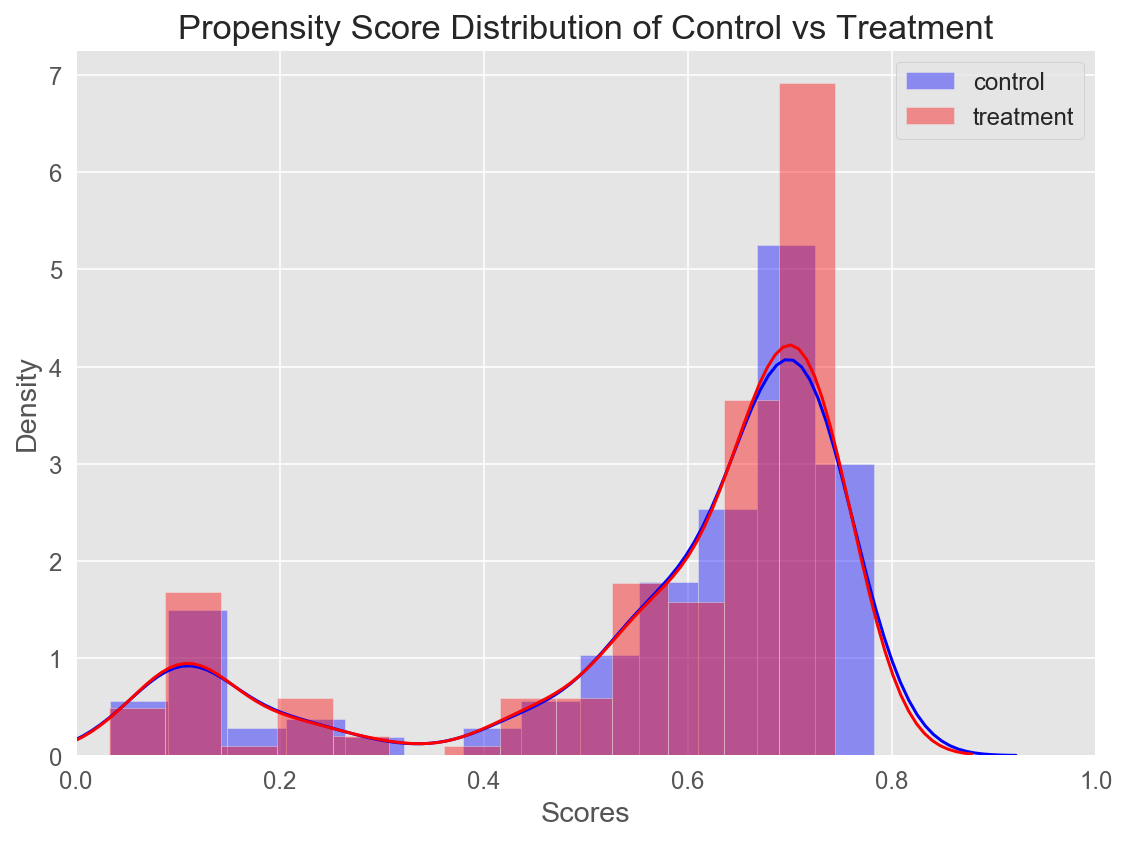

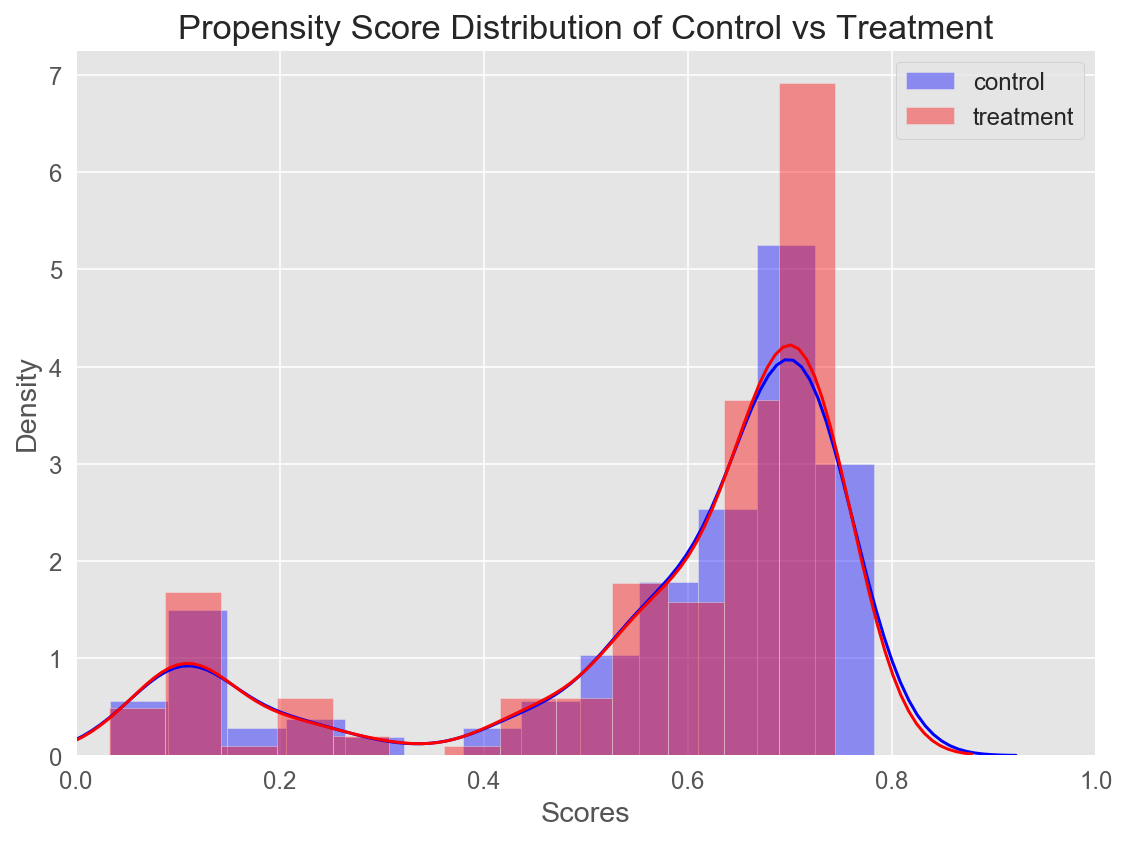

In [71]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

sns.distplot(p_scores_new[:mid_len], label='control',color='blue')
sns.distplot(p_scores_new[mid_len:], label='treatment',color='red')
plt.xlim(0, 1)
plt.title('Propensity Score Distribution of Control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

_Apparently the distribution in propensity score is more similar between groups. Note that we are also dealing with 185 cases in each group._

### Exercise 6 (45 min):

Assess covariate balance after the $k$-NN matching.  For this, compute the absolute standardized differences in means in the covariates after matching,  $$ASMD_a(x)=\frac{\bar{x}_{t,a}-{\bar{x}_{c,a}}}{\sqrt{\frac{s^{2}_{t,b} + s^{2}_{c,b}}{2}}},$$ where $\bar{x}_{t,a}$ and $\bar{x}_{c,a}$ are, respectively, the means of covariate $x$ in the treatment and control groups after matching, and $s^{2}_{t,b}$ and $s^{2}_{c,b}$ are, correspondingly, the sample variances treatment and control groups **before matching**. 

One reason to use the sample variances before matching rather than the sample variances after matching is to free the comparisons of the means after matching from simultaneous changes in the variances. Comment on covariate balance.

**Answer.**

_This required a function that is similar to the one written before, except that the standard deviations will be obtained from data **before** matching._

In [72]:
def ASMD(df,df_matched, var_treatment):
    
    
    def legend(smd_value):
        if smd_value<=0.1:
            text='OK'
            
        elif smd_value>0.1 and smd_value<0.2:
            text='Not balanced, but acceptable'
        
        else:
            text='Serioulsy Imbalanced'

        return text

    
    list_var=[]
    list_val=[]
    
    my_vars=[var for var in df.columns if var!=var_treatment]
    for _,var in enumerate(my_vars):
    
   
        # group1: Series or NumPy array
        # group2: Series or NumPy array
        # returns a floating point number
    
        group1_am=df_matched.loc[df_matched[var_treatment]==0,var]
        group2_am=df_matched.loc[df_matched[var_treatment]==1,var]
    
        #note that means are calculated after matching
        diff = group1_am.mean() - group2_am.mean()
    
        #Using a general length
        #Should size matter?
        #n1, n2 = len(group1), len(group2)
        
        #And variances are calculated before matching
        
        group1_bm=df.loc[df[var_treatment]==0,var]
        group2_bm=df.loc[df[var_treatment]==1,var]
        
        var1 = group1_bm.var()
        var2 = group2_bm.var()
    
        # Calculate the pooled threshold 
    
        #pooled_var = (n1*var1 + n2*var2) / (n1+n2)
        pooled_var=(var1+var2)/2
    
    # Calculate value
        d1 = abs(diff / np.sqrt(pooled_var))
        list_var.append(var)
        list_val.append(d1)
    
    
    
    result=pd.DataFrame(zip(list_var,list_val),columns=['Variable Name','ASMD value'])
    result.sort_values(by='Variable Name',inplace=True)
    
    result['text']=result['ASMD value'].apply(legend)
    
    return result
                 

In [73]:
ASMD(lalonde_df,df_matched,'treat')

Variable Name  ASMD value                          text
0           age    0.066145                            OK
2         black    0.014076                            OK
1          educ    0.124774  Not balanced, but acceptable
3        hispan    0.018094                            OK
4       married    0.120172  Not balanced, but acceptable
5      nodegree    0.102672  Not balanced, but acceptable
6          re74    0.167022  Not balanced, but acceptable
7          re75    0.200733          Serioulsy Imbalanced
8          re78    0.158258  Not balanced, but acceptable

Variable Name  ASMD value                          text
0           age    0.066145                            OK
2         black    0.014076                            OK
1          educ    0.124774  Not balanced, but acceptable
3        hispan    0.018094                            OK
4       married    0.120172  Not balanced, but acceptable
5      nodegree    0.102672  Not balanced, but acceptable
6          re74    0.167022  Not balanced, but acceptable
7          re75    0.200733          Serioulsy Imbalanced
8          re78    0.158258  Not balanced, but acceptable

_Note that the matching has reduced the values when compared to original data._



### Exercise 7 (25 min):

Estimate the average effect of treatment on <font color='red'> wages (`re78`) </font> after matching. What do you conclude?

**Answer.**

In [74]:
df_matched.groupby(['treat'])['re78'].agg(['mean','median','count'])

mean    median  count
treat                              
0      5148.567388  2451.548    185
1      6349.143530  4232.309    185

mean    median  count
treat                              
0      5148.567388  2451.548    185
1      6349.143530  4232.309    185

In [75]:
lalonde_df.groupby(['treat'])['re78'].agg(['mean','median','count'])

mean    median  count
treat                              
0      6984.169742  4975.505    429
1      6349.143530  4232.309    185

mean    median  count
treat                              
0      6984.169742  4975.505    429
1      6349.143530  4232.309    185

_After the matching treatment, we conclude that - using mean value as a first criteria - the treatment seems to have a positive effect on mean earnings, which is the opposite of what we had found before._

## Propensity score matching using decision trees and random forests

### Exercise 8 (Optional) - (70 min):

To validate our propensity score calculations, let's try calculating them using other models such as decision trees and random forests.

#### 8.1

Build a decision tree regressor where the outcome variable is whether a subject was in the treatment group or not, and the covariates are all the other variables except `re78`. Use the `sklearn.tree` function `DecisionTreeRegressor(max_depth=4)` and call the new propensity scores `pscore_tree`.

**Answer.**

In [76]:
from sklearn.tree import DecisionTreeRegressor
DT=DecisionTreeRegressor(max_depth=4)

In [77]:
DT.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [78]:
pscore_tree=DT.predict(X)

#### 8.2

Plot the decision tree regressor using the code

```
fig = plt.gcf()
fig.set_size_inches(150, 100)
tree.plot_tree(dt,filled=True,feature_names=cleaned_df.columns)
fig.savefig('tree.png')
```

Replace `dt` with the name of the model created in Exercise 8.1. Use the plot to estimate the probability that a 24 year old, single, uneducated (less than 10 years of educ) Hispanic individual that earned $\$20000$ in 1974 was enrolled in the employment program. Do the same with a black man with the same characteristics. (Assume that there were no black Hispanics in the study.)

**Answer.**

In [79]:

fig = plt.gcf()
fig.set_size_inches(150, 100)
tree.plot_tree(DT,filled=True,feature_names=cleaned_df.columns)
fig.savefig('tree.png')



In [80]:
X.sample(1)

age      educ  black  hispan  married  nodegree  re74  re75
NSW16  0.076923  0.555556      1       0        0         1   0.0   0.0

age      educ  black  hispan  married  nodegree  re74  re75
NSW16  0.076923  0.555556      1       0        0         1   0.0   0.0

In [81]:
vars_not_cat=['age','educ','re74','re75']

In [82]:
X_new_a=pd.DataFrame([24,10,20000,0]).T
X_new_a.columns=vars_not_cat


In [83]:
X_new_scaled=mms.transform(X_new_a)

In [84]:
X.head(1)

age      educ  black  hispan  married  nodegree  re74  re75
NSW1  0.538462  0.611111      1       0        1         1   0.0   0.0

age      educ  black  hispan  married  nodegree  re74  re75
NSW1  0.538462  0.611111      1       0        1         1   0.0   0.0

In [85]:
X_new_scaled

array([[0.20512821, 0.55555556, 0.57077512, 0.        ]])

array([[0.20512821, 0.55555556, 0.57077512, 0.        ]])

_Predicting for a 24 year old, single, uneducated (less than 10 years of educ) Hispanic individual that earned  $20000 in 1974 was enrolled in the employment program._

In [86]:
DT.predict(np.array([[0.20512821, 0.55555556, 0,1,0,0,0.57077512, 0.        ]]))

array([0.])

array([0.])

_And we predict that this Hispanic person didn't participate._

_Doing the same with a non hispanic african american man with the other same characteristics. (Assuming that there were no black Hispanics in the study)._

In [87]:
DT.predict(np.array([[0.20512821, 0.55555556, 1,0,0,0,0.57077512, 0.        ]]))

array([0.59459459])

array([0.59459459])

_And we predict that the Hispanic person participated, using a cutoff of 0.5._

#### 8.3

Estimate the propensity scores now by using random forests. For the model, use the `sklearn.ensemble` function `RandomForestClassifier` with parameters `n_estimators=100, max_depth=4, random_state=42`. Then, use the method `predict_proba` to extract the propensity scores. Name the scores `pscore_forest`.

**Answer.**

In [88]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)

In [89]:
rf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [90]:
pscore_forest=rf.predict_proba(X)[:,1]

#### 8.4

Make a plot with the three ROC curves corresponding to the logistic regression, decision tree, and random forest classifiers used to compute the propensity scores. What is the AUC of each model? Which model *seems* to do the best job?

**Answer.**

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.874
Tree: ROC AUC=0.926
Random Forest: ROC AUC=0.932
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.874
Tree: ROC AUC=0.926
Random Forest: ROC AUC=0.932


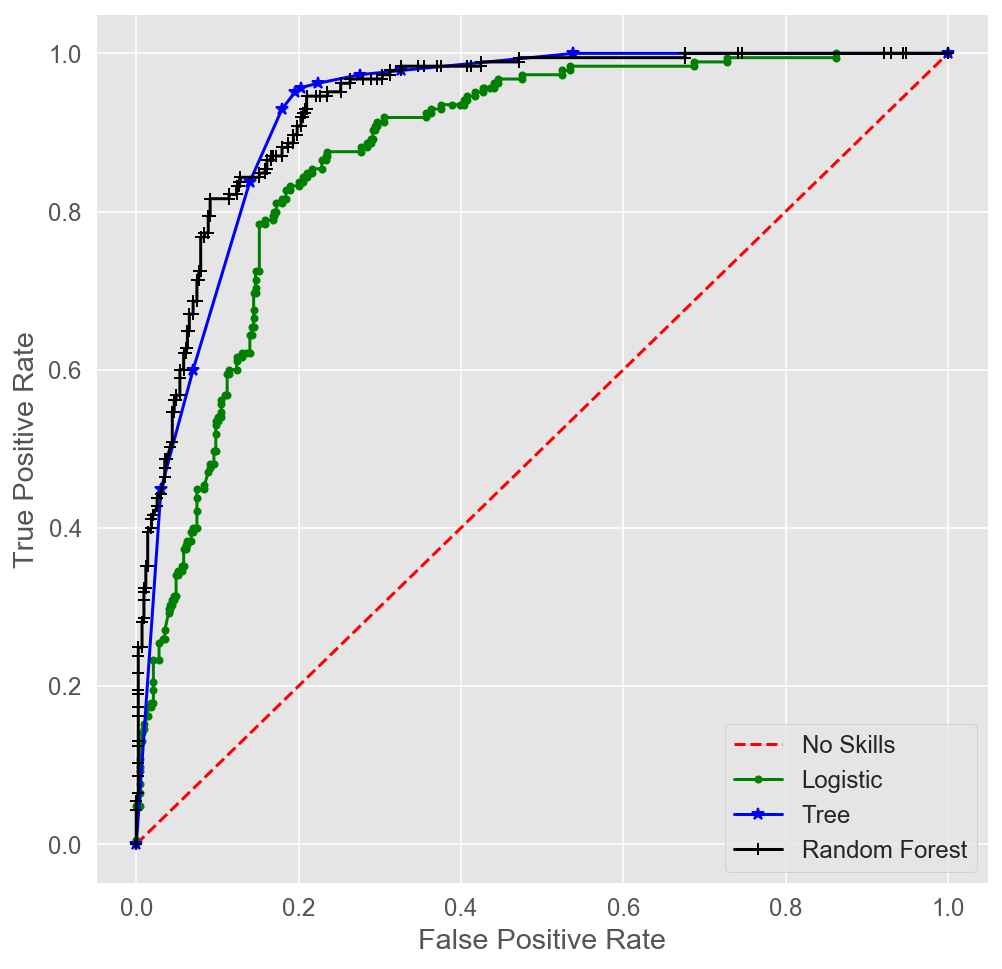

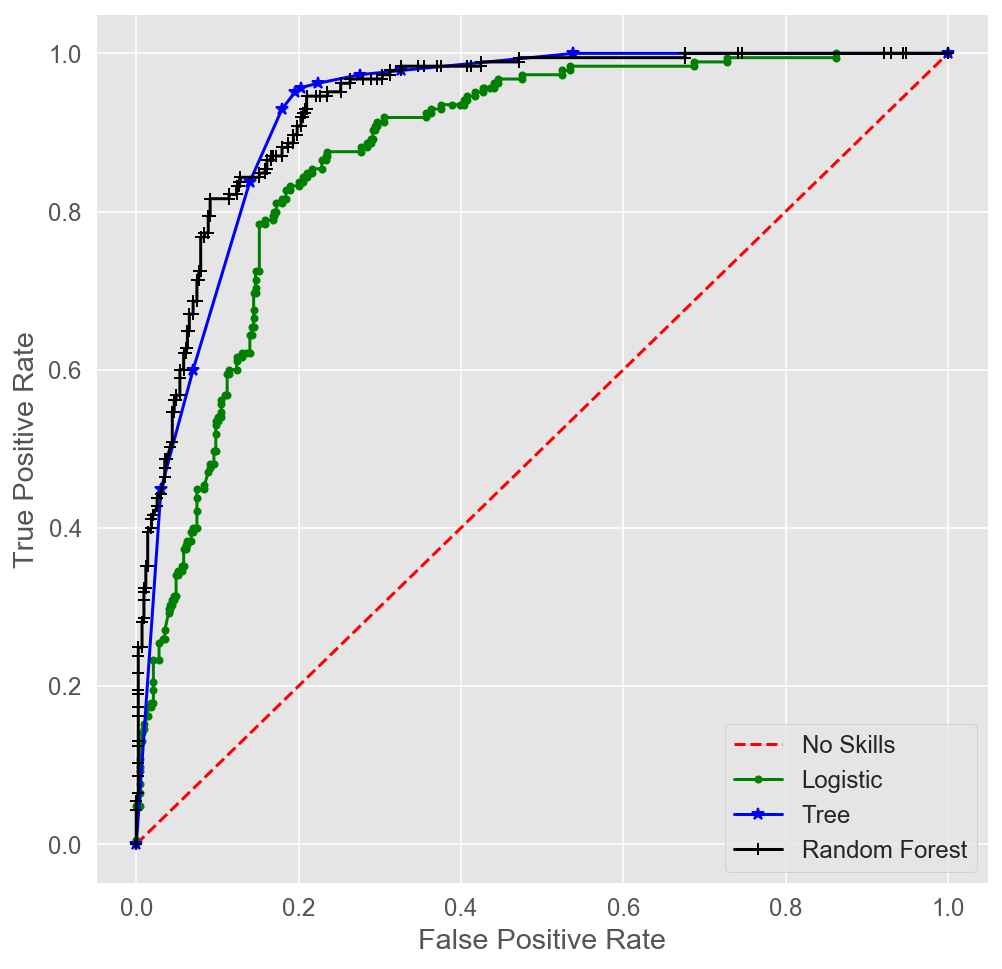

In [91]:
plt.figure(figsize=(8,8))
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix,f1_score
from sklearn.metrics import roc_auc_score

# predict probabilities
ns_probs = [0 for _ in range(len(y))]
lr_probs = pscore_logit
dt_probs = pscore_tree
rf_probs = pscore_forest


# keep probabilities for the positive outcome only
#lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y, ns_probs)
lr_auc = roc_auc_score(y, lr_probs)
dt_auc=roc_auc_score(y, dt_probs)
rf_auc=roc_auc_score(y, rf_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
print('Tree: ROC AUC=%.3f' % (dt_auc))
print('Random Forest: ROC AUC=%.3f' % (rf_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y, lr_probs)
dt_fpr, dt_tpr, _ = roc_curve(y, dt_probs)
rf_fpr, rf_tpr, _ = roc_curve(y, rf_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skills',color='red')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic',color='green')
plt.plot(dt_fpr, dt_tpr, marker='*', label='Tree',color='blue')
plt.plot(rf_fpr, rf_tpr, marker='+', label='Random Forest',color='black')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

_It seems that using a Tree would be the best alternative. Random Forest has a slightly higher AUC but tree models are simpler._

#### 8.5

Consider the following statement:

>  "*A model with a higher AUC provides much better estimates of the true propensity scores. In particular, a matching using the propensity scores of such a model will balance the covariates much better.*"

Is the statement true or false? Explain. 

**Answer.**

_Not necessarily True, so it is False. We are using propensity scores matching to acknowledge the effect of confounding factors. A very complex model could be a hindrance or at least make more difficult this task, or even give undesired results._

#### 8.6

Repeat the matching procedure now with the estimated propensity scores `pscore_tree` and `pscore_forest`. Assess the covariate balances and estimate the average effect of treatment on wages (`re78`) after matching. Compare your results. 

**Answer.**

In [92]:
mask=y==1

In [93]:
pos_pscore_tree=pscore_tree[mask]
neg_pscore_tree=pscore_tree[~mask]

In [94]:
sim_distances, sim_indices = get_similar(pos_pscore_tree,neg_pscore_tree)

In [95]:
indices=sim_indices[:,0]

df_pos=lalonde_df[mask]
df_neg=lalonde_df[~mask].iloc[indices]
df_matched=pd.concat([df_pos, df_neg], axis=0)

_Checking..._

In [96]:
df_matched.treat.value_counts()

1    185
0    185
Name: treat, dtype: int64

1    185
0    185
Name: treat, dtype: int64

In [97]:
ASMD(lalonde_df,df_matched,'treat')

Variable Name  ASMD value                          text
0           age    0.836847          Serioulsy Imbalanced
2         black    0.000000                            OK
1          educ    0.468451          Serioulsy Imbalanced
3        hispan    0.090471                            OK
4       married    0.636912          Serioulsy Imbalanced
5      nodegree    0.159713  Not balanced, but acceptable
6          re74    0.062651                            OK
7          re75    0.226458          Serioulsy Imbalanced
8          re78    0.535947          Serioulsy Imbalanced

Variable Name  ASMD value                          text
0           age    0.836847          Serioulsy Imbalanced
2         black    0.000000                            OK
1          educ    0.468451          Serioulsy Imbalanced
3        hispan    0.090471                            OK
4       married    0.636912          Serioulsy Imbalanced
5      nodegree    0.159713  Not balanced, but acceptable
6          re74    0.062651                            OK
7          re75    0.226458          Serioulsy Imbalanced
8          re78    0.535947          Serioulsy Imbalanced

In [98]:
df_matched.groupby(['treat'])['re78'].agg(['mean','median','count'])

mean    median  count
treat                              
0      2283.343059     0.000    185
1      6349.143530  4232.309    185

mean    median  count
treat                              
0      2283.343059     0.000    185
1      6349.143530  4232.309    185

_When using Random Forest we obtain:_

In [99]:
pos_pscore_rf=pscore_forest[mask]
neg_pscore_rf=pscore_forest[~mask]

In [100]:
sim_distances, sim_indices = get_similar(pos_pscore_rf,neg_pscore_rf)

In [101]:
indices=sim_indices[:,0]

df_pos=lalonde_df[mask]
df_neg=lalonde_df[~mask].iloc[indices]
df_matched=pd.concat([df_pos, df_neg], axis=0)

In [102]:
ASMD(lalonde_df,df_matched,'treat')

Variable Name  ASMD value                          text
0           age    0.101579  Not balanced, but acceptable
2         black    0.154832  Not balanced, but acceptable
1          educ    0.067860                            OK
3        hispan    0.126660  Not balanced, but acceptable
4       married    0.120172  Not balanced, but acceptable
5      nodegree    0.136896  Not balanced, but acceptable
6          re74    0.116474  Not balanced, but acceptable
7          re75    0.210481          Serioulsy Imbalanced
8          re78    0.097074                            OK

Variable Name  ASMD value                          text
0           age    0.101579  Not balanced, but acceptable
2         black    0.154832  Not balanced, but acceptable
1          educ    0.067860                            OK
3        hispan    0.126660  Not balanced, but acceptable
4       married    0.120172  Not balanced, but acceptable
5      nodegree    0.136896  Not balanced, but acceptable
6          re74    0.116474  Not balanced, but acceptable
7          re75    0.210481          Serioulsy Imbalanced
8          re78    0.097074                            OK

In [103]:
df_matched.groupby(['treat'])['re78'].agg(['mean','median','count'])

mean    median  count
treat                              
0      5612.717119  5495.665    185
1      6349.143530  4232.309    185

mean    median  count
treat                              
0      5612.717119  5495.665    185
1      6349.143530  4232.309    185

_It seems that Logit seems to give better results than both of these new more sofisticated and non parametric estimators. Random Forest is OK but the Regression Tree should be discarded for this dataset._

#### 8.7

Why do you think the decision tree regressor performed badly on balancing the covariates of the treat and control groups?  

**Hint:** Look at the distances of the ten nearest neighbors output by `.kneighbors()` for the propensity scores of the decision tree model. What do you see? Why do you think these distances may have an impact on balancing?

**Answer.**

In [104]:
mask=y==1

pos_pscore=pscore_tree[mask]
neg_pscore=pscore_tree[~mask]

sim_distances, sim_indices = get_similar(pos_pscore,neg_pscore)

In [105]:
print(sim_distances)

[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0

[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0

"Closest neighbors" are usually at a zero distance and one is very far! No room to balance, so the obtained indexes are meaningless.